Figuring out how to output roundness/sharpness, and looking into
what happens when using two different aperture sizes.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry,CircularAnnulus,CircularAperture
from photutils import DAOStarFinder

In [2]:
# image = 'hor1DRCs/jdan20010_drc.fits'
# hdu = fits.open(image)
# sci = hdu[1].data
# hdr = hdu[0].header
# tab = hdu[4].data
# photflam = hdu[1].header['PHOTFLAM']

# data = hdu[1].data
# hdu.close()

# temp_sci=data*hdr['texptime']

# fits.writeto('hor1DRCs/F814W_ctsALL_raw.fits', temp_sci, header=hdr)

In [2]:
image = 'hor1DRCs/F814W_ctsALL_raw.fits'
# fits.info(image)

hdu = fits.open(image)
sci = hdu[0].data
hdr = hdu[0].header
hdu.close()

In [3]:
data = sci.copy()

In [4]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0, maxiters=5)
print(mean, median, std)

0.49618652 -0.06826966 19.541706


In [5]:
daofind = DAOStarFinder(fwhm=2., threshold=5.*std)
sources = daofind(data - median)
print(len(sources))

6557


In [6]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures_r4 = CircularAperture(positions, r=4.)

rawflux_r4 = aperture_photometry(data, apertures_r4)

In [7]:
rawflux_r4['roundness1']= sources['roundness1']
rawflux_r4['roundness2']= sources['roundness2']
rawflux_r4['sharpness']= sources['sharpness']

In [8]:
annulus_apertures = CircularAnnulus(positions, r_in=9., r_out=12.)

annulus_masks = annulus_apertures.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)

In [9]:
rawflux_r4['annulus_median'] = bkg_median
rawflux_r4['aper_bkg'] = bkg_median*apertures_r4.area
rawflux_r4['final_phot'] = rawflux_r4['aperture_sum'] - rawflux_r4['aper_bkg']

In [10]:
apertures_r6 = CircularAperture(positions, r=6.)
rawflux_r6 = aperture_photometry(data, apertures_r6)

rawflux_r6['aper_bkg'] = rawflux_r4['annulus_median']*apertures_r6.area
rawflux_r6['final_phot'] = rawflux_r6['aperture_sum'] - rawflux_r6['aper_bkg']

In [11]:
mask_negative = (rawflux_r4['final_phot'] > 0) & (rawflux_r6['final_phot'] > 0)

rawflux_pos_r4 = rawflux_r4[mask_negative]
rawflux_pos_r6 = rawflux_r6[mask_negative]

mag_r4 = -2.5*np.log10(rawflux_pos_r4['final_phot'])
mag_r6 = -2.5*np.log10(rawflux_pos_r6['final_phot'])

deltamag = mag_r4 - mag_r6

/Users/hr8jz/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


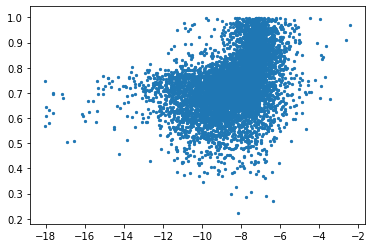

In [120]:
fig,ax = plt.subplots()

ax.scatter(mag_r4,rawflux_pos_r4['sharpness'],s=5)

plt.show()

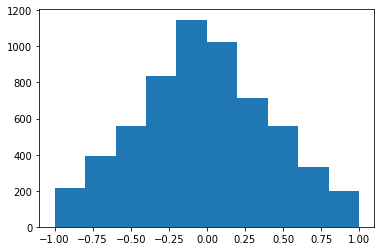

In [115]:
plt.hist(rawflux_pos_r4['roundness1'])
plt.show()

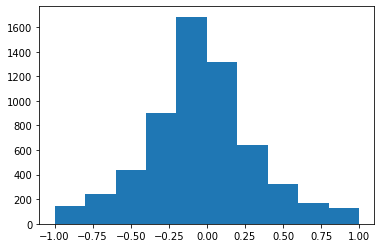

In [116]:
plt.hist(rawflux_pos_r4['roundness2'])
plt.show()

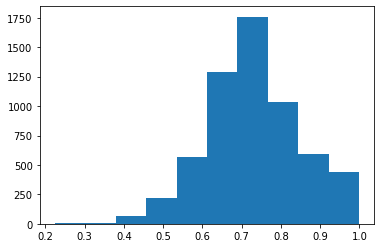

In [117]:
plt.hist(rawflux_pos_r4['sharpness'])
plt.show()

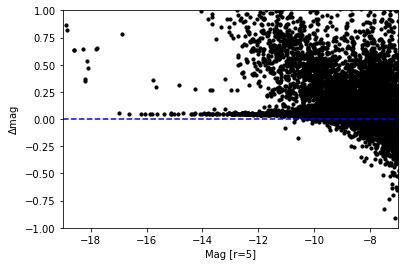

In [12]:
plt.figure()
plt.scatter(mag_r6, deltamag, c='k', s=10)
plt.axhline(ls='--', c='b')
plt.xlim(-19,-7)
plt.ylim(-1,1)
plt.xlabel('Mag [r=5]')
plt.ylabel('$\Delta$mag')

plt.show()

0.049956437237242746


Text(0, 0.5, '$\\Delta$mag')

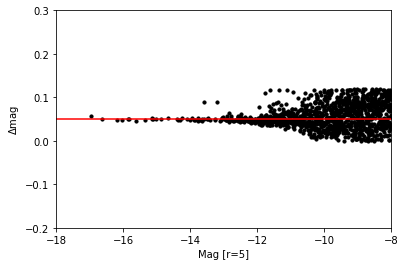

In [202]:
mask = (mag_r6 > -17.) & (mag_r6 < -8.) & (deltamag > 0) & (deltamag < 0.1)

mean, median, std = sigma_clipped_stats(deltamag[mask], sigma=3.0, maxiters=5)
apcor = median
print(apcor)

new_mask = (mag_r6 > -17.) & (mag_r6 < -8.) & (deltamag > 0) & (deltamag < apcor + 1.5*std)

plt.figure()
plt.scatter(mag_r6[new_mask], deltamag[new_mask], c='k', s=10)
plt.axhline(apcor,ls='-',c='r')
plt.xlim(-18,-8)
plt.ylim(-0.2,0.3)
plt.xlabel('Mag [r=5]')
plt.ylabel('$\Delta$mag')

In [126]:
test1 = mag_r6[new_mask]

In [127]:
len(test1)

938

In [66]:
len(mask)

5986

In [129]:
mask[:10]

array([False,  True, False, False, False, False,  True, False, False,
       False])

In [130]:
newCol = np.zeros((len(mask),1))
for ii in range(len(mask)):
    if mask[ii]==True:
        newCol[ii]=int(1)
    else:
        newCol[ii]=int(0)

In [131]:
rawflux_pos_r4['six_4_flag'] = newCol

In [134]:
EEband = 0.77
ZPT = 26.779

In [135]:
final_phot = -2.5 * np.log10(rawflux_pos_r4['final_phot'] / EEband) \
            + 2.5 * np.log10(hdr['exptime']) + ZPT

In [136]:
rawflux_pos_r4['magr_f814w'] = final_phot

In [137]:
s0 = ' '
header = s0.join(rawflux_pos_r4.dtype.names)

In [138]:
np.savetxt('./drcPhot02Nov/HOROLOGIUM-I_newFlag.dat',rawflux_pos_r4,header=header)

In [99]:
print(len(test1)/5986) # approximately 5 percent of sources are kept

0.220180420982292


In [72]:
sg = np.genfromtxt('./catRawMags20Aug/catDir_HOROLOGIUM-I/classStarCat_F606Wmatch_HOROLOGIUM-I.dat',
                  names=True)

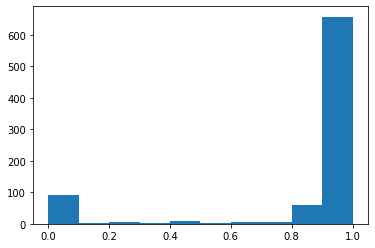

In [73]:
plt.hist(sg['c_star_f606w'])
plt.show()

In [81]:
sg_mask = sg['c_star_f606w'] > 0.8

In [82]:
test = sg[sg_mask]
print(len(test)/len(sg))

0.8497041420118343


In [83]:
len(test)

718

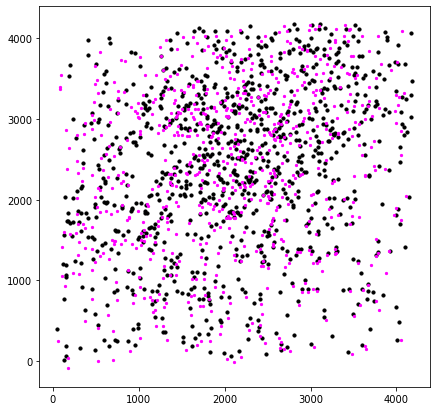

In [128]:
fig, ax = plt.subplots(figsize=(7,7))


ax.scatter(rawflux_pos_r4['xcenter'][new_mask],
           rawflux_pos_r4['ycenter'][new_mask],s=10,color='black')
ax.scatter(sg['xt1_f606w'][sg_mask],sg['yt1_f606w'][sg_mask],s=5,color='magenta')


plt.show()

In [51]:
len(sg)

845

In [144]:
newM = np.genfromtxt('./drcPhot02Nov/sePU10Nov/HOROLOGIUM-I_fullSEpu.dat',names=True)

In [196]:
len(newM)

1419

In [145]:
mask = newM['six_4_flag']==1

In [172]:
mask2 = newM['class_Star_i']>=0.95

In [163]:
mask3 = (newM['six_4_flag']==1) & (newM['class_Star_i']>=0.9)
good3=newM[mask3]
print(len(good3))

725


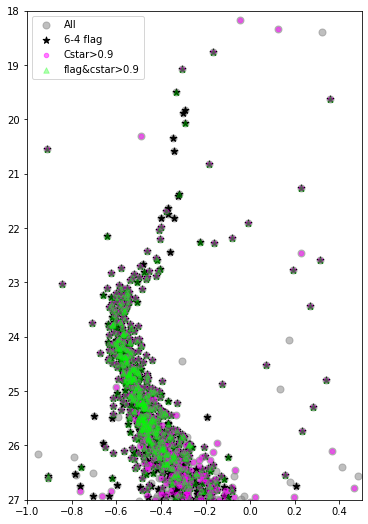

In [198]:
fig,ax = plt.subplots(figsize=(6,9))

ax.scatter(newM['magRaw_v']-newM['magRaw_i'],newM['magRaw_v'],s=50,
           color='grey',label='All',alpha=0.5)
ax.scatter(good['magRaw_v']-good['magRaw_i'],good['magRaw_v'],s=50,marker='*',
           color='black',label='6-4 flag')
ax.scatter(good2['magRaw_v']-good2['magRaw_i'],good2['magRaw_v'],s=20,
           alpha=0.5,label='Cstar>0.9',color='magenta')
ax.scatter(good3['magRaw_v']-good3['magRaw_i'],good3['magRaw_v'],s=30,
           alpha=0.3,label='flag&cstar>0.9',color='lime',marker='^')


#1419,850, 831, 725 -- 938 intially passed the flag test
ax.set_ylim(27,18)
ax.set_xlim(-1,0.5)
ax.legend()

plt.show()

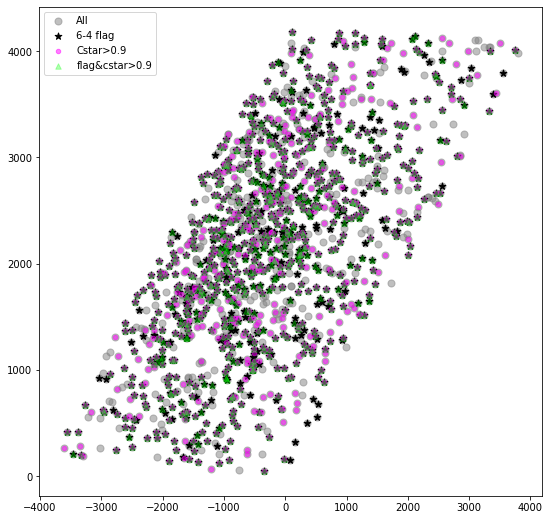

In [200]:
fig,ax = plt.subplots(figsize=(9,9))

ax.scatter(newM['x_v']-newM['y_v'],newM['x_v'],s=50,
           color='grey',label='All',alpha=0.5)
ax.scatter(good['x_v']-good['y_v'],good['x_v'],s=50,marker='*',
           color='black',label='6-4 flag')
ax.scatter(good2['x_v']-good2['y_v'],good2['x_v'],s=20,
           alpha=0.5,label='Cstar>0.9',color='magenta')
ax.scatter(good3['x_v']-good3['y_v'],good3['x_v'],s=30,
           alpha=0.3,label='flag&cstar>0.9',color='lime',marker='^')


#1419,850, 831, 725 -- 938 intially passed the flag test
# ax.set_ylim(27,18)
# ax.set_xlim(-1,0.5)
ax.legend()

plt.show()

In [173]:
good2 = newM[mask2]
print(len(good2))

831


In [146]:
good = newM[mask]

In [148]:
len(good)

850

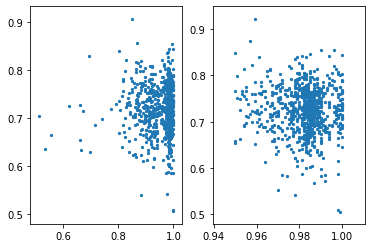

In [156]:
fig,(ax1,ax2) = plt.subplots(1,2)


ax1.scatter(good['class_Star_i'],good['sharpness'],s=5)
ax2.scatter(good2['class_Star_i'],good2['sharpness'],s=5)

plt.show()


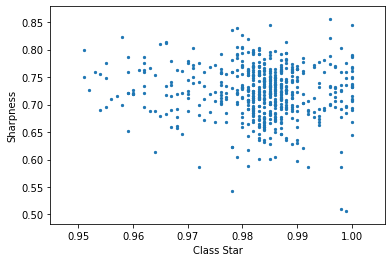

In [161]:
fig,ax = plt.subplots()


# ax1.scatter(good['class_Star_i'],good['sharpness'],s=5)
ax.scatter(good3['class_Star_i'],good3['sharpness'],s=5)
ax.set_xlabel('Class Star')
ax.set_ylabel('Sharpness')

plt.show()


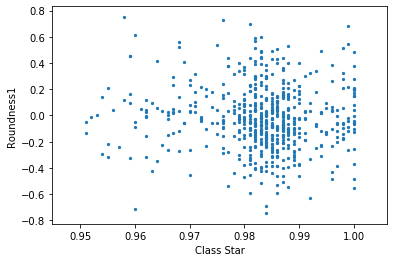

In [162]:
fig,ax = plt.subplots()


# ax1.scatter(good['class_Star_i'],good['sharpness'],s=5)
ax.scatter(good3['class_Star_i'],good3['roundness1'],s=5)
ax.set_xlabel('Class Star')
ax.set_ylabel('Roundness1')

plt.show()


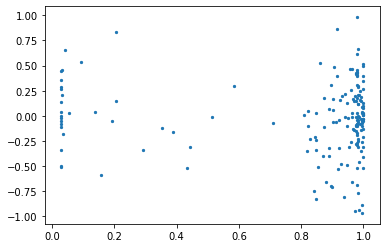

In [143]:
fig,ax = plt.subplots()


ax.scatter(newM['c_star_f814w'],newM['roundness1'],s=5)

plt.show()

In [16]:
image = 'hor1DRCs/jdan20010_drc.fits'

# fits.info(image)

hdu = fits.open(image)
hdr = hdu[0].header
photflam = hdu[1].header['PHOTFLAM']

hdu.close()

In [22]:
other = -2.5*np.log10(photflam/hdr['texptime']/0.839)
print(other)

56.73998765094548


In [18]:
ap_cor = -2.5 * np.log10(0.839)
print(ap_cor)

0.19059509792824936


In [19]:
zpt = 26.779

In [20]:
final_phot = -2.5*np.log10(rawflux_pos_r4['final_phot']) - apcor + zpt
print(final_phot[:20])

    final_phot    
------------------
 20.35397257440397
 18.58672007905273
 19.79914061920007
16.506791463510748
18.492237715742093
 16.70951992861134
 18.44681254040968
17.913452190357013
17.538297481614954
18.916625729695877
17.632906105590184
 19.29276336485581
17.260061384691596
 16.32444186019248
16.831581429919378
 20.08607464327332
19.013617836537787
18.664997338917207
 18.85544068551983
19.242314260365582


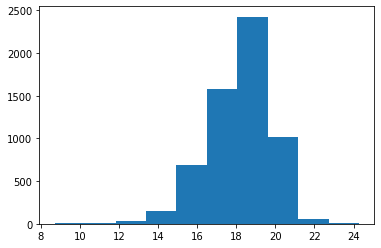

In [21]:
plt.hist(final_phot)
plt.show()